In [1]:
from ipumspy import readers, ddi, IpumsApiClient, AggregateDataExtract, Dataset, DatasetMetadata
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from matplotlib.ticker import FuncFormatter
import arcgis
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.raster import Raster
from arcgis.features import GeoAccessor
import geopandas as gpd
import glob
from zipfile import ZipFile
import earthaccess as ea
import requests
import pprint

In [9]:
arcgis.__version__

'2.4.0'

In [2]:
#Load the IPUMS API key from the .env file

load_dotenv()

IPUMS_API_KEY = os.getenv("IPUMS_API_KEY")
ipums = IpumsApiClient(IPUMS_API_KEY)

In [ ]:
#Submit pulling to IPUMS 

extract = AggregateDataExtract(
    collection="nhgis",
    description="Puerto Rico 2010-2020 vacancy",
    datasets=[
        Dataset(name="2010_SF1a", data_tables=["H1", "H3"], geog_levels=["block"]),
        Dataset(name = "2020_DHCa", data_tables = ["H1", "H3"], geog_levels = ["block"])
    ],
    geographic_extents=["720"],
    shapefiles=["720_block_2020_tl2020"]
)

In [ ]:
#Getting shapefile metadata

ds = ipums.get_metadata(DatasetMetadata("nhgis", "2010_SF1a"))
for page in ipums.get_metadata_catalog("nhgis", metadata_type="shapefiles"):
    for shapefile in page["data"]:
        if shapefile["extent"] == "Puerto Rico" and shapefile["geographicLevel"] == "Block":
            print( "Name: " + shapefile["name"] + " | Year: " + shapefile["year"])

Name: 720_block_2000_tl2010 | Year: 2000
Name: 720_block_2010_tl2010 | Year: 2010
Name: 720_block_2010_tl2020 | Year: 2010
Name: 720_block_2020_tl2020 | Year: 2020


In [ ]:
#Submit the extract request
ipums.submit_extract(extract)
print(f"Extract ID: {extract.extract_id}")

#Wait for the extract to finish
ipums.wait_for_extract(extract)

#Download the extract
current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data")
ipums.download_extract(extract, download_dir=DOWNLOAD_DIR)

Extract ID: 13


In [3]:
#Reading from zip file

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data")

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[0]}"
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

In [ ]:
# Check what is inside the zip
print(csv_data)
print(shape_data)

['nhgis0013_csv/nhgis0013_ds258_2020_block.csv', 'nhgis0013_csv/nhgis0013_ds258_2020_block_codebook.txt', 'nhgis0013_csv/nhgis0013_ds172_2010_block.csv', 'nhgis0013_csv/nhgis0013_ds172_2010_block_codebook.txt']
['nhgis0013_shape/nhgis0013_shapefile_tl2020_720_block_2020.zip']


In [4]:
# Read zip data file in the extract
with ZipFile(shapefile) as outer_zip: # Shapefile data has 2 zipped layers
    with outer_zip.open(shape_data[0]) as inner_zip:
        with ZipFile(inner_zip) as inner:
            inner.extractall(DOWNLOAD_DIR) #Extract the shapefile into the data folder
            

In [4]:
#Read csv data

with ZipFile(csv) as z:
    with z.open(csv_data[0]) as f: 
        df_2020 = pd.read_csv(f)
    with z.open(csv_data[2]) as f:
        df_2010 = pd.read_csv(f)

In [57]:
shp_df = pd.DataFrame.spatial.from_featureclass(location = "./data/PR_block_2020.shp", sr = 3857)

In [6]:
## Using earthaccess to search and find 

url = "https://cmr.earthdata.nasa.gov/search/collections?concept_id[]=C123456-LPDAAC_ECS"

query = ea.search_datasets(keyword = "LECZ")
for collection in query[:10]:
    pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
    print('')  # Add a space between collections for readability

{   'concept-id': 'C1000000400-SEDAC',
    'file-type': "[{'Format': 'CSV', 'Fees': '0'}, {'Format': 'Excel', 'Fees': "
                 "'0'}, {'Format': 'PDF', 'Fees': '0'}, {'Format': 'PNG', "
                 "'Fees': '0'}, {'Format': 'WMS', 'Fees': '0'}]",
    'get-data': [   'https://search.earthdata.nasa.gov/search/granules?p=C1000000400-SEDAC'],
    'short-name': 'CIESIN_SEDAC_LECZ_URPLAEV2',
    'version': '2.00'}

{   'concept-id': 'C3104974973-SEDAC',
    'file-type': "[{'Format': 'Excel', 'Fees': '0'}, {'Format': 'PDF', 'Fees': "
                 "'0'}, {'Format': 'PNG', 'Fees': '0'}]",
    'get-data': [   'https://search.earthdata.nasa.gov/search/granules?p=C3104974973-SEDAC'],
    'short-name': 'CIESIN_SEDAC_LECZ_DELTA_V1',
    'version': '1.00'}

{   'concept-id': 'C2187533258-SEDAC',
    'file-type': "[{'Format': 'Excel', 'Fees': '0'}, {'Format': 'GeoTIFF', "
                 "'Fees': '0'}, {'Format': 'PDF', 'Fees': '0'}, {'Format': "
                 "'PNG', 'Fees': '0

In [ ]:
# #Login to the Earthdata
# # Create a username and password in .env file where you stored IPUMS API key
# auth = ea.login(strategy= "environment")

# #Download the data through the Earthdata
# Query = (
#     ea.granule_query()
#     .short_name("CIESIN_SEDAC_LECZ_URPLAEV3")
#     .debug(True)
# )

# print(f"Granule hits: {Query.hits()}")

# # Get the first 10 granules
# granules = Query.get(10)

# #Check if the granules are cloud hosted
# granules[1].cloud_hosted
# download_file = ea.download(granules[1], local_path="./data")

Granule hits: 2


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
#Load data to the notebook

tiff = [f for f in file_list if f.endswith('-geotiff.zip')]

tiff_path = os.path.join(f"{DOWNLOAD_DIR}/{tiff[0]}")


with ZipFile(tiff_path) as z:
    z.extractall(DOWNLOAD_DIR)

In [21]:
file_list

['nhgis0013_csv.zip',
 'nhgis0013_shape.zip',
 'PR_block_2020.cpg',
 'PR_block_2020.dbf',
 'PR_block_2020.GISJOIN.atx',
 'PR_block_2020.prj',
 'PR_block_2020.sbn',
 'PR_block_2020.sbx',
 'PR_block_2020.shp',
 'PR_block_2020.shp.xml',
 'PR_block_2020.shx']

In [ ]:
df_2010.shape, df_2020.shape, shp_df.shape

((77189, 62), (41987, 63), (41320, 19))

In [ ]:
df_2020.head()

,GISJOIN,YEAR,STUSAB,GEOID,GEOCODE,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,...,NAME,FUNCSTAT,INTPTLAT,INTPTLON,LSADC,UGA,U9V001,U9X001,U9X002,U9X003
0,G72000109563001000,2020,PR,1000000US720019563001000,720019563001000,9,0,Puerto Rico,72,Adjuntas Municipio,...,Block 1000,S,18.231874,-66.771935,BK,99999,68,68,60,8
1,G72000109563001001,2020,PR,1000000US720019563001001,720019563001001,9,0,Puerto Rico,72,Adjuntas Municipio,...,Block 1001,S,18.220806,-66.776888,BK,99999,46,46,45,1
2,G72000109563001002,2020,PR,1000000US720019563001002,720019563001002,9,0,Puerto Rico,72,Adjuntas Municipio,...,Block 1002,S,18.221548,-66.782006,BK,99999,22,22,11,11
3,G72000109563001003,2020,PR,1000000US720019563001003,720019563001003,9,0,Puerto Rico,72,Adjuntas Municipio,...,Block 1003,S,18.218566,-66.764885,BK,99999,43,43,32,11
4,G72000109563001004,2020,PR,1000000US720019563001004,720019563001004,9,0,Puerto Rico,72,Adjuntas Municipio,...,Block 1004,S,18.213141,-66.761705,BK,99999,31,31,31,0


In [58]:
#Rename the columns the human readable names
# The NHGIS codes are as follows in the documentation which is downloaded from the IPUMS API 

'''    Table 1:     Housing Units
    Universe:    Housing units
    Source code: H1
    NHGIS code:  U9V
        U9V001:      Total
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  U9X
        U9X001:      Total
        U9X002:      Occupied
        U9X003:      Vacant
'''

rename = {
    "U9V001": "Total_Housing",
    "U9X001": "Total_Housing_Units",
    "U9X002": "Occupied",
    "U9X003": "Vacant"
}

df_2010.rename(columns = rename, inplace = True)
df_2020.rename(columns = rename, inplace = True)


shp_census = shp_df.merge(df_2020[["GISJOIN", "Total_Housing", "Total_Housing_Units", "Occupied", "Vacant"]], on = "GISJOIN", how = "inner")
shp_census.head()

,index,GISJOIN,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,...,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,SHAPE,OBJECTID,Total_Housing,Total_Housing_Units,Occupied,Vacant
0,0,G72000109563001000,72,001,956300,1000,720019563001000,Block 1000,G5040,,...,+18.2318743,-066.7719354,15320.205987,5.732655e+06,"{""rings"": [[[3160379.290100001, -1629030.51910...",0,68,68,60,8
1,1,G72000109563001001,72,001,956300,1001,720019563001001,Block 1001,G5040,,...,+18.2208062,-066.7768876,2695.184677,2.039819e+05,"{""rings"": [[[3161709.5944, -1631274.0355000002...",1,46,46,45,1
2,2,G72000109563001002,72,001,956300,1002,720019563001002,Block 1002,G5040,,...,+18.2215480,-066.7820065,3462.974754,5.103265e+05,"{""rings"": [[[3160676.727600001, -1631115.7275]...",2,22,22,11,11
3,3,G72000109563001003,72,001,956300,1003,720019563001003,Block 1003,G5040,,...,+18.2185664,-066.7648852,2372.120012,1.443076e+05,"{""rings"": [[[3162807.1435000002, -1631231.7259...",3,43,43,32,11
4,4,G72000109563001004,72,001,956300,1004,720019563001004,Block 1004,G5040,,...,+18.2131414,-066.7617048,2645.836078,1.991987e+05,"{""rings"": [[[3163153.313099999, -1631340.5883]...",4,31,31,31,0


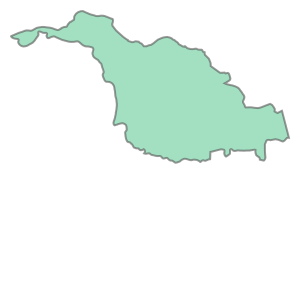

In [59]:
shp_census.SHAPE[0]

In [45]:
gis = GIS()
m1 = gis.map("Puerto Rico")
m1.basemap.basemap = "gray-vector"
m1

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [62]:
shp_census.spatial.plot(m1)

True

In [46]:
projection = m1.extent
print(projection)


{'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'xmin': -7568980.252293817, 'ymin': 1972166.0761602372, 'xmax': -7229599.84670765, 'ymax': 2155614.944044651}


In [ ]:
shp_df.head()

,index,GISJOIN,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,...,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,SHAPE,OBJECTID,Total_Housing,Total_Housing_Units,Occupied,Vacant
0,0,G72000109563001000,72,001,956300,1000,720019563001000,Block 1000,G5040,,...,+18.2318743,-066.7719354,15320.205987,5.732655e+06,"{""rings"": [[[3160379.290100001, -1629030.51910...",0,68,68,60,8
1,1,G72000109563001001,72,001,956300,1001,720019563001001,Block 1001,G5040,,...,+18.2208062,-066.7768876,2695.184677,2.039819e+05,"{""rings"": [[[3161709.5944, -1631274.0355000002...",1,46,46,45,1
2,2,G72000109563001002,72,001,956300,1002,720019563001002,Block 1002,G5040,,...,+18.2215480,-066.7820065,3462.974754,5.103265e+05,"{""rings"": [[[3160676.727600001, -1631115.7275]...",2,22,22,11,11
3,3,G72000109563001003,72,001,956300,1003,720019563001003,Block 1003,G5040,,...,+18.2185664,-066.7648852,2372.120012,1.443076e+05,"{""rings"": [[[3162807.1435000002, -1631231.7259...",3,43,43,32,11
4,4,G72000109563001004,72,001,956300,1004,720019563001004,Block 1004,G5040,,...,+18.2131414,-066.7617048,2645.836078,1.991987e+05,"{""rings"": [[[3163153.313099999, -1631340.5883]...",4,31,31,31,0


In [51]:
reproj = shp_census.copy()
reproj["SHAPE"] = reproj["SHAPE"].geom.project_as(102100)

In [70]:
shp_df.spatial.sr = 3857
shp_df.spatial.sr


{'wkid': 4326}

In [69]:
pip show shapely

Name: shapely
Version: 2.0.7
Summary: Manipulation and analysis of geometric objects
Home-page: 
Author: Sean Gillies
Author-email: 
License: BSD 3-Clause
Location: c:\Users\hidey\anaconda3\envs\dev-env\Lib\site-packages
Requires: numpy
Required-by: geopandas
Note: you may need to restart the kernel to use updated packages.


In [9]:
gis = GIS()

lecz_layer = gis.content.search("Low Elevation Coastal Zones derived from MERIT-DEM", item_type="Imagery Layer")
for item in lecz_layer:
    display(item)
lecz = lecz_layer[0]

<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>

<Item title:"Global population living within 10m of sea level (2015)" type:Tiled Imagery Layer owner:dasbury_storymaps>

In [6]:
census_sedf = GeoAccessor.from_geodataframe(gdf)

In [31]:
m2 = gis.map("Puerto Rico")
m2.content.add(census_sedf)

In [ ]:
m1 = gis.map("Puerto Rico")
m1.content.add(lecz)
census_sedf.spatial.plot(map_widget=m1, opacity=0.7)

True

In [11]:
m1

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [12]:
m1.content.layers

[<ImageryLayer url:"https://gis.earthdata.nasa.gov/image/rest/services/lecz/lecz_urban_rural_population_land_area_estimates_v3/ImageServer">,
 <FeatureCollection>]

In [13]:
m2 = gis.map("Puerto Rico")
census_sedf.spatial.plot(map_widget=m2, opacity=0.7)
m2

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [14]:
census_sedf.spatial.geometry_type

['polygon']

In [ ]:
census_sedf.head()

,GISJOIN,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,SHAPE
0,G72000109563001000,72,001,956300,1000,720019563001000,Block 1000,G5040,None,None,None,S,5732654.0,0.0,+18.2318743,-066.7719354,15320.205987,5.732655e+06,"{""rings"": [[[3160379.290100001, -1629030.51910..."
1,G72000109563001001,72,001,956300,1001,720019563001001,Block 1001,G5040,None,None,None,S,203982.0,0.0,+18.2208062,-066.7768876,2695.184677,2.039819e+05,"{""rings"": [[[3161709.5944, -1631274.0355000002..."
2,G72000109563001002,72,001,956300,1002,720019563001002,Block 1002,G5040,None,None,None,S,510327.0,0.0,+18.2215480,-066.7820065,3462.974754,5.103265e+05,"{""rings"": [[[3160676.727600001, -1631115.7275]..."
3,G72000109563001003,72,001,956300,1003,720019563001003,Block 1003,G5040,None,None,None,S,144307.0,0.0,+18.2185664,-066.7648852,2372.120012,1.443076e+05,"{""rings"": [[[3162807.1435000002, -1631231.7259..."
4,G72000109563001004,72,001,956300,1004,720019563001004,Block 1004,G5040,None,None,None,S,199199.0,0.0,+18.2131414,-066.7617048,2645.836078,1.991987e+05,"{""rings"": [[[3163153.313099999, -1631340.5883]..."
